In [1]:
import json, os, sys

print(os.getcwd())

/home/gridsan/hzli/CV-Fairness/fairness_cv_project/datasets/mscoco/multi_label


In [2]:
# load target id mapping
data_path = os.path.expanduser("~/CV-Fairness/data/datasets/mscoco/metadata/multi_label/target_to_id.json")
target_id_mapping = json.load(open(data_path))
id_target_mapping = {v: k for k, v in target_id_mapping.items()}
id_target_mapping

{0: 'bicycle',
 1: 'car',
 2: 'motorcycle',
 3: 'airplane',
 4: 'bus',
 5: 'train',
 6: 'truck',
 7: 'boat',
 8: 'traffic light',
 9: 'fire hydrant',
 10: 'stop sign',
 11: 'parking meter',
 12: 'bench',
 13: 'bird',
 14: 'cat',
 15: 'dog',
 16: 'horse',
 17: 'sheep',
 18: 'cow',
 19: 'elephant',
 20: 'bear',
 21: 'zebra',
 22: 'giraffe',
 23: 'backpack',
 24: 'umbrella',
 25: 'handbag',
 26: 'tie',
 27: 'suitcase',
 28: 'frisbee',
 29: 'skis',
 30: 'snowboard',
 31: 'sports ball',
 32: 'kite',
 33: 'baseball bat',
 34: 'baseball glove',
 35: 'skateboard',
 36: 'surfboard',
 37: 'tennis racket',
 38: 'bottle',
 39: 'wine glass',
 40: 'cup',
 41: 'fork',
 42: 'knife',
 43: 'spoon',
 44: 'bowl',
 45: 'banana',
 46: 'apple',
 47: 'sandwich',
 48: 'orange',
 49: 'broccoli',
 50: 'carrot',
 51: 'hot dog',
 52: 'pizza',
 53: 'donut',
 54: 'cake',
 55: 'chair',
 56: 'couch',
 57: 'potted plant',
 58: 'bed',
 59: 'dining table',
 60: 'toilet',
 61: 'tv',
 62: 'laptop',
 63: 'mouse',
 64: 'remo

In [13]:

# load datasets
from data_loader import MultiCocoLoader
from torchvision import transforms

img_size = 256
crop_size = 224

normalize_vec = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

data_transforms = {
  "train": transforms.Compose(
      [
          transforms.Resize(img_size),
          #transforms.RandomCrop(crop_size),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(*normalize_vec),
      ]
  ),
  "test": transforms.Compose(
      [
          transforms.Resize(img_size),
          transforms.CenterCrop(crop_size),
          transforms.ToTensor(),
          transforms.Normalize(*normalize_vec),
      ]
  )
}

In [14]:
data_path = os.path.expanduser("~/CV-Fairness/data/datasets/mscoco")
images_path = os.path.join(data_path, "images2014/")
train_antn_file = os.path.join(data_path, "metadata/multi_label/train.json")
antns = json.load(open(train_antn_file, "r"))
len(antns)

20211

In [15]:
train_data = MultiCocoLoader(images_path, train_antn_file, transform=data_transforms["train"])

loading annotations into memory...
20211 annotations loaded


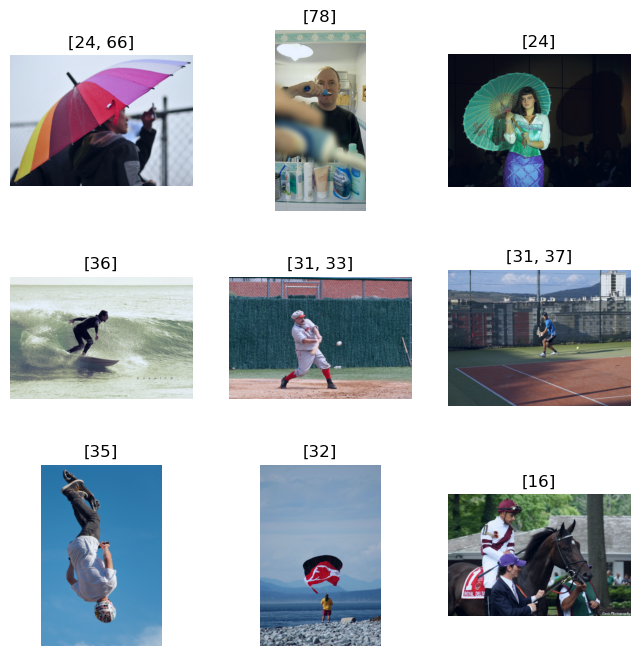

In [16]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, labels = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels)
    plt.axis("off")
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.to(torch.uint8)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

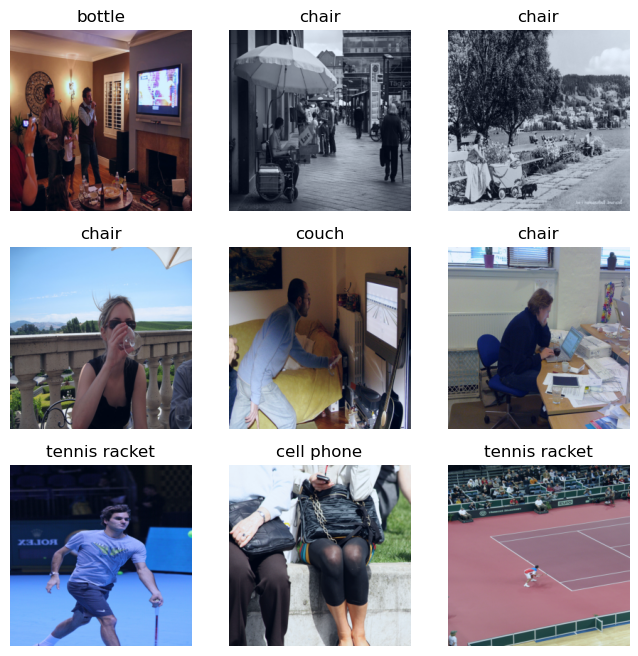

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label, img_id = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(id_target_mapping[label])
    plt.axis("off")
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.to(torch.uint8)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

# Test output of model

In [7]:
os.chdir("../../..//saved_models/mscoco")
print(os.getcwd())

/home/gridsan/hzli/CV-Fairness/saved_models/mscoco


In [8]:
import torch
import torchvision.models as models
import torch.nn as nn

print(os.getcwd())
model = models.resnet50()

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # replace the last FC layer
model = model.to(torch.device("cpu"))

state_dict = torch.load("baseline/balanced.pt", map_location=torch.device('cpu'))
model.load_state_dict(state_dict)


/home/gridsan/hzli/CV-Fairness/saved_models/mscoco


<All keys matched successfully>

In [9]:
os.chdir("../../data/datasets/mscoco/")
print(os.getcwd())

/home/gridsan/hzli/CV-Fairness/data/datasets/mscoco


In [10]:
img, label, img_id = test_data[0]
device = torch.device("cpu")
model.eval()
outputs = model(img.unsqueeze(0).to(device))
_, preds = torch.max(outputs, 1)
print("expected: ", id_target_mapping[label], "predicted: ", id_target_mapping[preds.item()])

expected:  tennis racket predicted:  tennis racket


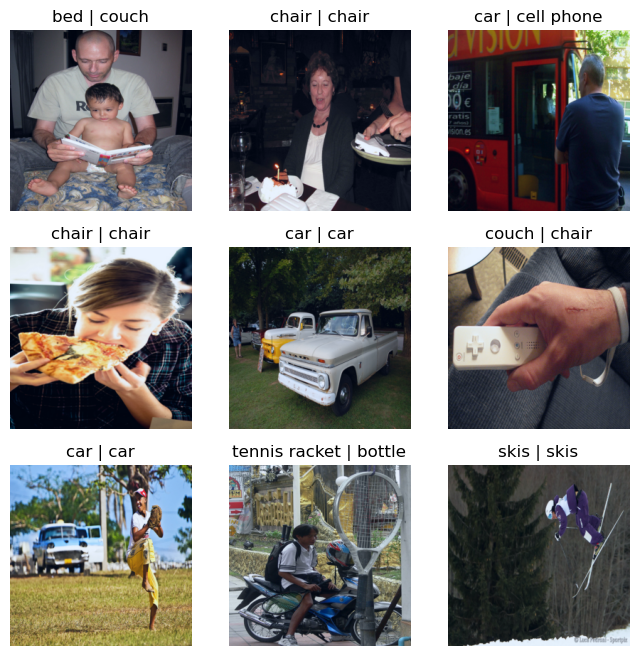

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
model.eval()
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label, img_id = test_data[sample_idx]
    img.to(device)
    outputs = model(img.unsqueeze(0))
    _, preds = torch.max(outputs, 1)
    figure.add_subplot(rows, cols, i)
    plt.title(id_target_mapping[label] + " | " + id_target_mapping[preds.item()])
    plt.axis("off")
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.to(torch.uint8)
    plt.imshow(img.permute(1, 2, 0))
plt.show()